
# Topic classification in text documents

How to balance the text data before to train a classifier.

In [44]:
## Load libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from collections import Counter

from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


## Understand the dataset


**The 20 newsgroups dataset** is a popular dataset for text classification and clustering tasks. It contains newsgroup documents, partitioned across 20 different newsgroups.


Data Set Characteristics:
- Classes: 20
- Samples total: 18846
- Dimensionality: 1
- Features: text

Since it is a text dataset, the workflow is the following:
1. Preprocessing the data: We'll preprocess the data by removing stop words and converting the text to lowercase. Stop words are a set of commonly used words in a language. Examples of stop words in English are “a,” “the,” “is,” “are,” etc. 
2. Convert it to numerical features : We'll use the TF-IDF vectorizer to convert the text data to numerical features. The TF-IDF vectorizer is a tool that transforms text into numerical values based on the frequency of words (Term Frequency) and how unique or rare those words are across multiple documents (Inverse Document Frequency), helping to highlight important words in the text.
3. Visualize it with some dimensionality reduction: We can use a word cloud to visualize the most frequent words in the dataset. Additionally, we can use t-SNE to visualize the data in 2D space. t-SNE (t-distributed Stochastic Neighbor Embedding) is a technique that reduces the dimensionality of data, transforming it into a 2D or 3D space while preserving the relationships between data points, making it easier to visualize complex datasets.

In [20]:
from sklearn.datasets import fetch_20newsgroups

# Load the dataset
newsgroups_data = fetch_20newsgroups(subset='all')
print(newsgroups_data.DESCR)
print(newsgroups_data.target_names)
print (f"{len(newsgroups_data.target_names)=}")

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

In [42]:
# Example of one pair of one post and its corresponding label
print (newsgroups_data.data[1])

print (newsgroups_data.target[1], newsgroups_data.target_names[1])

From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)
Subject: Which high-performance VLB video card?
Summary: Seek recommendations for VLB video card
Nntp-Posting-Host: midway.ecn.uoknor.edu
Organization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA
Keywords: orchid, stealth, vlb
Lines: 21

  My brother is in the market for a high-performance video card that supports
VESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:

  - Diamond Stealth Pro Local Bus

  - Orchid Farenheit 1280

  - ATI Graphics Ultra Pro

  - Any other high-performance VLB card


Please post or email.  Thank you!

  - Matt

-- 
    |  Matthew B. Lawson <------------> (mblawson@essex.ecn.uoknor.edu)  |   
  --+-- "Now I, Nebuchadnezzar, praise and exalt and glorify the King  --+-- 
    |   of heaven, because everything he does is right and all his ways  |   
    |   are just." - Nebuchadnezzar, king of Babylon, 562 B.C.           |   

3 comp.graphics


In [21]:
# Preprocess the Data

import nltk
nltk.download('stopwords')

import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stop_words = set(stopwords.words('english')).union(set(ENGLISH_STOP_WORDS))
# This converts the list of stop words into a set. Sets are collections of unique elements, and using a set ensures that there are no duplicate stop words.
# The union method of a set combines two sets and returns a new set containing all unique elements from both sets.

print (stop_words)

def preprocess(text):
    # Remove non-alphanumeric characters and convert to lowercase
    text = re.sub(r'\W+', ' ', text).lower()
    # 1. Splits the input text into words.
    # 2. Filters out any words that are in the stop_words set.
    # 3. Joins the remaining words back into a single string with spaces in between.
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

preprocessed_data = [preprocess(text) for text in newsgroups_data.data]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jrobador/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'former', 'too', 'everyone', 'we', 'thick', 'detail', 're', 'however', 'perhaps', 'would', 'aren', 'together', 'same', 'sometime', 'thence', 'was', 'find', 'having', 'per', 'before', 'once', 'sometimes', 'were', 't', 'most', 'yet', 'to', 'll', 'no', 'fifteen', 've', 'give', 'neither', 'few', 'i', 'why', 'thereupon', 'yourselves', 'more', 'made', 'could', 'how', 'below', 'somehow', 'moreover', 'noone', 'at', 'in', 'nine', 'ie', 'get', 'seemed', 'as', 'them', 'de', "should've", 'have', 'had', 'nothing', 'whereby', 'out', 'first', 'his', 'becomes', 'what', 'weren', 'fifty', 'should', 'off', "wasn't", 'else', "that'll", 'where', 'whereafter', 'does', 'therein', "mightn't", 'hereafter', 'several', 'this', 'system', 'one', 'nevertheless', 'third', 'those', 'your', 'latter', 'haven', 'sincere', 'forty', 'anyway', 'thus', 'for', "don't", 'theirs', 'if', 'just', 'anyone', 'towards', 'above', 'might', 'although', 'thereby', 'eight', 'itself', 'amount', 'enough', 'everything', 'again', 'isn', 'd

In [33]:
# Convert Text Data to Numerical Features

vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(preprocessed_data)
y = newsgroups_data.target


print (X.shape)
print (y.shape)

(18846, 2000)
(18846,)


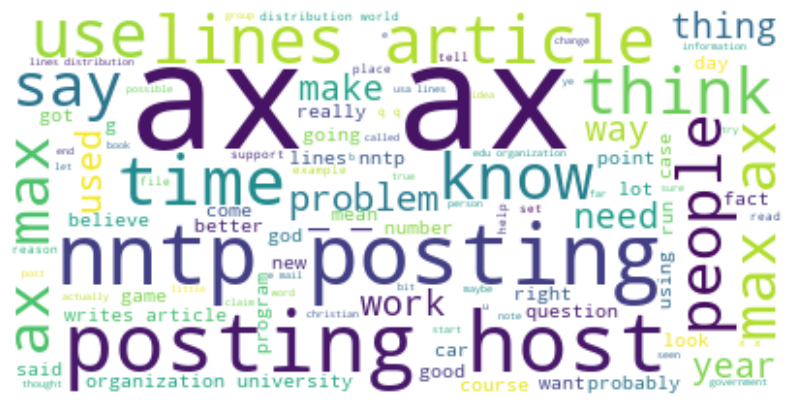

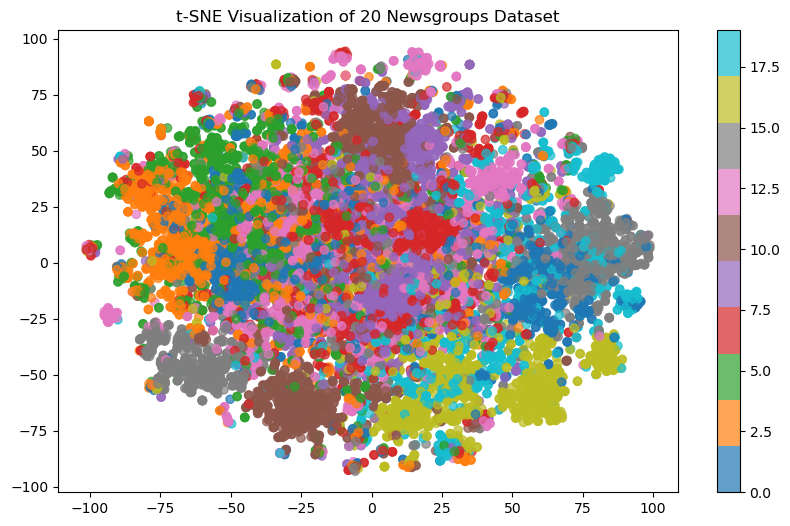

In [25]:
# Visualize the Data
from wordcloud import WordCloud
from sklearn.manifold import TSNE

# Create a word cloud
wordcloud = WordCloud(max_words=100, background_color='white').generate(' '.join(preprocessed_data))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Use t-SNE to reduce dimensions and visualize the data
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X.toarray())

# Plot the t-SNE result
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.colorbar(scatter)
plt.title('t-SNE Visualization of 20 Newsgroups Dataset')
plt.show()

## Setting the data set for imbalanced purpose

However, we are going a part of the 20 newsgroups data set by loading 4 topics.


In [62]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]
newsgroups_train = fetch_20newsgroups(subset="train", categories=categories)
newsgroups_test = fetch_20newsgroups(subset="test", categories=categories)

X_train = newsgroups_train.data
X_test = newsgroups_test.data

y_train = newsgroups_train.target
y_test = newsgroups_test.target

print(f"Training class distributions summary: {Counter(y_train)}")
print(f"Test class distributions summary: {Counter(y_test)}")

Training class distributions summary: Counter({2: 593, 1: 584, 0: 480, 3: 377})
Test class distributions summary: Counter({2: 394, 1: 389, 0: 319, 3: 251})


Note the class \#3 is the minority class. Nevertheless, imbalanced ratio is not THAT bad (specifically 1.57, meaning class 3 has about 1.57 times fewer samples than class 2.).

## Scikit-learn pipeline

We are going to do predictions with this imbalanced dataset. The pipeline structure is the following:
1. TFidVectorizer to convert text to numerical features
2. Naive Bayes classifier for multinomial models.

In [63]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Results (before balancing dataset)

### Information about metrics used on imbalanced datasets

This report compiles the state-of-the-art metrics: precision/recall/specificity, f1 score, geometric mean, and index balanced accuracy of the geometric mean.

### Metrics definition

#### Precision ('pre')
Precision measures how many of the **positive predictions made by the model** were actually correct. A higher precision indicates fewer false positives.

                Precision = TP/TP+FP
- TP (True Positives): Correctly predicted positive cases.
- FP (False Positives): Incorrectly predicted as positive.

#### Recall ('rec')
Recall measures how many of the **actual positive cases were identified** by the model. A higher recall means fewer missed positive cases.

                Recall = TP/TP+FN

- FN (False Negatives): Incorrectly predicted as negative.

####  Specificity ('spe')
Specificity measures how many of the **actual negative cases were identified** correctly by the model. It is particularly useful for evaluating the performance in detecting negative cases.

                Specifity = TN/TN+FP

![metrics](./img/metrics.png)

####  F1 Score ('f1')
The F1 score balances precision and recall into a single metric. It’s particularly useful when the class distribution is imbalanced and you want to evaluate the model’s performance on the minority class.

F1=2* (Precision*Recall)/(Precision+Recall)

#### Geometric Mean ('geo')
The geometric mean provides a balance between recall and specificity, especially useful in imbalanced datasets where one class may be more prevalent.

Geo = (Recall * Specificity)**1/2


#### Index of Balanced Accuracy ('iba')
​This metric averages recall and specificity to provide a balanced measure of the model’s performance.

IBA = 0.5 * (Recall+Specificity)

#### Support ('sup')
Support is the number of occurrences of each class in the dataset. It provides context for other metrics by showing how many instances of each class are present.




In [64]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.67      0.94      0.86      0.79      0.90      0.82       319
          1       0.96      0.92      0.99      0.94      0.95      0.90       389
          2       0.87      0.98      0.94      0.92      0.96      0.92       394
          3       0.97      0.36      1.00      0.52      0.60      0.33       251

avg / total       0.87      0.84      0.94      0.82      0.88      0.78      1353



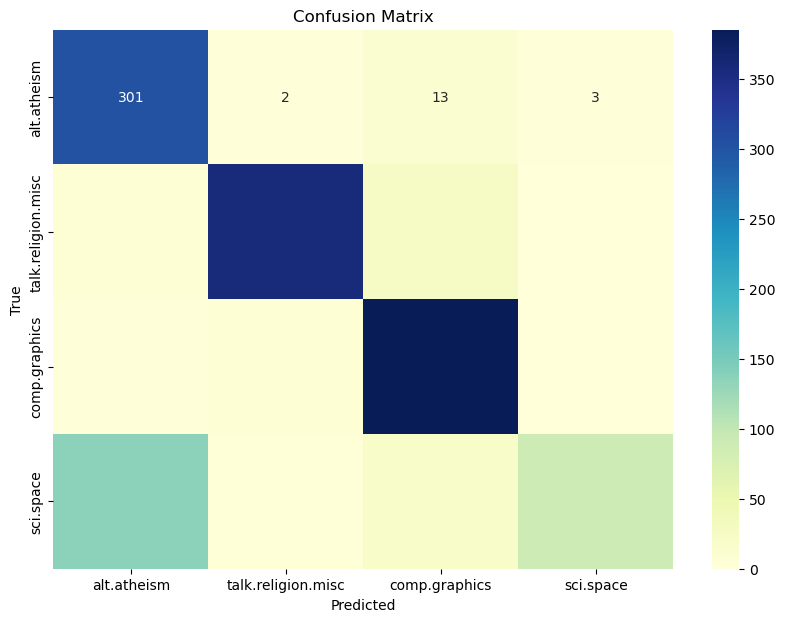

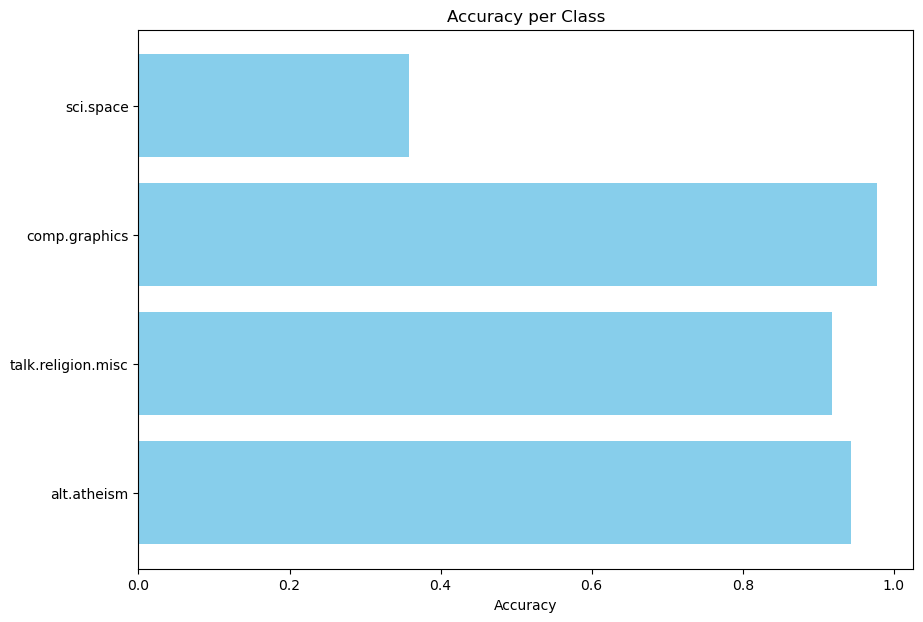

In [65]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

accuracy_per_class = cm.diagonal() / cm.sum(axis=1)

# Plot accuracy per class
plt.figure(figsize=(10, 7))
plt.barh(np.arange(len(categories)), accuracy_per_class, color='skyblue')
plt.yticks(np.arange(len(categories)), categories)
plt.xlabel('Accuracy')
plt.title('Accuracy per Class')
plt.show()

As expected, the recall and accuracy of the class \#3 is low mainly due to the class imbalanced.

## Balancing the class before classification

To improve the prediction of the class #3, it could be interesting to apply a balancing before to train the naive bayes classifier. Therefore, we will use a RandomUnderSampler to equalize the number of samples in all the classes before the training.

In [66]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb

from imblearn.under_sampling import RandomUnderSampler

model = make_pipeline_imb(TfidfVectorizer(), RandomUnderSampler(), MultinomialNB())

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Results (after balancing dataset)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.69      0.91      0.87      0.78      0.89      0.80       319
          1       0.97      0.84      0.99      0.90      0.91      0.82       389
          2       0.94      0.89      0.98      0.91      0.93      0.86       394
          3       0.83      0.73      0.97      0.77      0.84      0.68       251

avg / total       0.87      0.85      0.95      0.85      0.90      0.80      1353



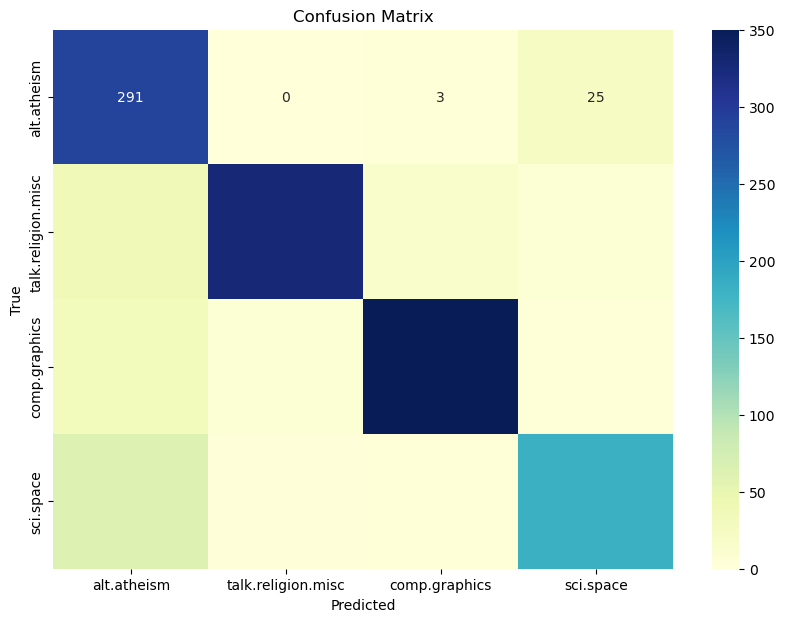

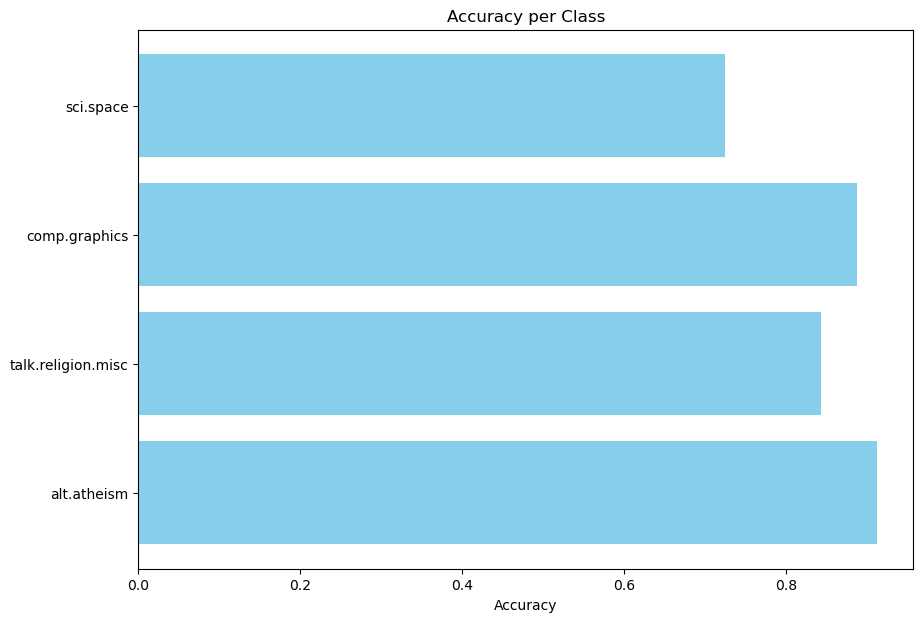

In [67]:
print(classification_report_imbalanced(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

accuracy_per_class = cm.diagonal() / cm.sum(axis=1)

# Plot accuracy per class
plt.figure(figsize=(10, 7))
plt.barh(np.arange(len(categories)), accuracy_per_class, color='skyblue')
plt.yticks(np.arange(len(categories)), categories)
plt.xlabel('Accuracy')
plt.title('Accuracy per Class')
plt.show()

## Conclusion

Based on the results of balancing the dataset using RandomUnderSampler in the pipeline:
1. Improvement in Recall for Minority Class (Class 3):

- Before balancing, the recall for class 3 was very low at 0.36, indicating that the model was missing a significant number of true instances of this class.
- After balancing, the recall for class 3 improved to 0.74, demonstrating that the model is now better at identifying true instances of this minority class.

2. Changes in Precision:

- Precision for class 3 dropped from 0.97 to 0.78. This is expected because balancing the dataset often involves undersampling the majority classes, which can introduce more false positives.
- Precision for classes 0, 1, and 2 remained relatively stable or improved slightly.

3. Overall Performance:

- The overall F1 score improved slightly from 0.82 to 0.85, suggesting a more balanced performance across all classes.
- The average recall also improved from 0.84 to 0.85, indicating that the model is now better at capturing true instances across all classes.

4. Trade-offs:

- While the precision for the minority class (class 3) decreased, this trade-off is often acceptable in scenarios where **recall** (identifying all true instances) is more critical than precision (correctness of positive predictions).

5. Model Selection:

- The results demonstrate that using techniques like RandomUnderSampler to balance the dataset can lead to more equitable model performance, especially when dealing with imbalanced datasets.
